# Clustering using the `K-means` method to select groups of objects

In this task, we will consider the <code>K-means</code> clustering method to solve the clustering problem itself - the problem of selecting similar structures in data. We will work with the well-known <a href="http://yann.lecun.com/exdb/mnist/"><code>MNIST</code></a> dataset.

Let's load the dataset. We will use only the test part of the original set to reduce the training time of the models.

In [1]:
from keras.datasets import mnist
import warnings
warnings.filterwarnings("ignore")

(_,_), (X, y) = mnist.load_data()

An example of outputting multiple objects and the corresponding class labels:

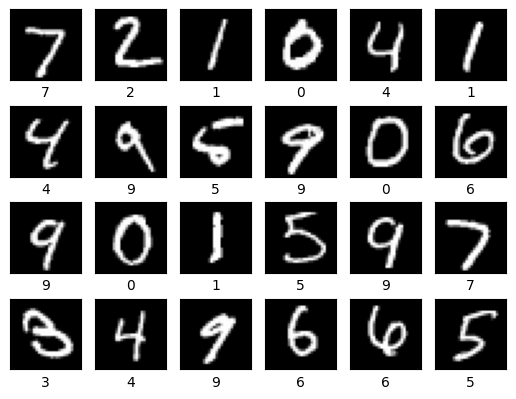

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i],
                   color='black')

Enter the <code>.shape</code> of the resulting dataset

In [3]:
print(X.shape)

(10000, 28, 28)


Split the dataset into training and test samples using <code>train_test_split</code> with parameters specified in your assignment.

In [4]:
from sklearn.model_selection import train_test_split
random_state = 41

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =random_state)

Since we are talking about a known dataset, let's make <code>K-means</code> search for $10$ groups of objects. 

"Straighten" the images and train the algorithm <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html"><code>KMeans</code></a> on the training dataset with the parameters specified in your assignment.

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10, random_state = random_state)
clusters = kmeans.fit_predict(X_train.reshape(-1, 784))

Determine the number of elements assigned to the cluster specified in your assignment.

In [7]:
from collections import Counter
print(dict(Counter(clusters)))

{9: 1205, 8: 582, 4: 712, 3: 584, 0: 968, 2: 677, 1: 1166, 6: 719, 7: 802, 5: 585}


Construct images corresponding to centroids of the obtained clusters. To do this, `reshape` coordinates of centroids to the size $28 \times 28$ and build the resulting matrix, for example, in black and white shades.

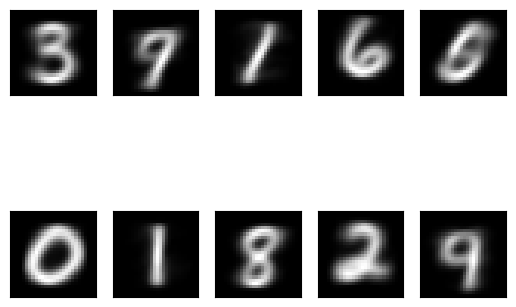

In [9]:
fig, ax = plt.subplots(2,5)
centers = kmeans.cluster_centers_.reshape(10,28,28)
for ax1, center in zip(ax.flat, centers):
    ax1.set(xticks = [], yticks =[])
    ax1.imshow(center, cmap = 'gray')

It can be seen that the resulting pictures look very similar to handwritten digits. However, the clustering was not without problems. Assume which digits may be mixed up and which digits are missing.

Since the resulting clusters know nothing about the nature of the objects being clustered, the labels of the clusters may differ from the "reasonable labels". Reconstruct the correct labels using the following considerations: a cluster is assigned the label of those digits whose representatives are the majority in the cluster. Did it really help to restore fairness?

Enter the obtained cluster labels after transformation via comma and space and compare with previously constructed images based on centroids. Are your assumptions confirmed by facts?

In [58]:
from scipy.stats import mode
import numpy as np
corrected_clusters = np.zeros_like(clusters)
cluster_values= []
for i in range(10):
    mask = (clusters == i)
    corrected_clusters[mask] = mode(y_train[mask])[0]
    cluster_values.append(mode(y_train[mask])[0])

In [61]:
print([x[0] for x in cluster_values])

TypeError: 'int' object is not subscriptable

In [62]:
from scipy.stats import mode
import numpy as np

corrected_clusters = np.zeros_like(clusters)
cluster_values = []

for i in range(10):
    mask = (clusters == i)
    mode_result = mode(y_train[mask])
    
    if isinstance(mode_result.mode, np.ndarray):
        corrected_clusters[mask] = mode_result.mode[0]
        cluster_values.append(mode_result.mode[0])
    else:
        corrected_clusters[mask] = mode_result.mode.item()
        cluster_values.append(mode_result.mode.item())

print(cluster_values)


[3, 7, 1, 6, 5, 0, 1, 8, 2, 4]


It is reasonable to estimate something like accuracy. Assuming that all objects in the cluster have the same label as the cluster itself, compare these labels to the true labels. Calculate <code>accuracy</code> for the training dataset. We recommend using the function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html"><code>accuracy_score</code></a> from the <code>sklearn</code> library.

In [34]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, corrected_clusters))

0.594625


Use the <code>.predict()</code> method to cluster the test dataset. Rename the labels of the predicted clusters based on the transformation obtained for the training dataset.

In [40]:
clusters_test = kmeans.predict(X_test.reshape(-1, 784))
labels_test = np.zeros_like(clusters_test)

for i in range(10):
    mask = (clusters_test == i)
    cluster_value = cluster_values[i]

    if isinstance(cluster_value, np.ndarray):  # Check if cluster_value is an array
        labels_test[mask] = cluster_value[0]
    else:
        labels_test[mask] = cluster_value

print(labels_test)


[5 3 0 ... 3 4 4]


Construct the confusion matrix.

In [41]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, labels_test)
print(mat)

[[156   0   0   7   0  27   4   0   2   0]
 [  0 210   0   1   0   0   0   0   0   0]
 [  0  35 144   9   6   4   5   3   5   0]
 [  0   9   7 148   2   6   0   4  26   0]
 [  1   8   0   0 106  12   7  63   0   0]
 [  1  10   0  64   8  53   1  12  22   0]
 [  6  10   0   0   2  43 130   0   0   0]
 [  0  20   5   0  44   0   0 136   0   0]
 [  2  14   1  21   3  17   3  10 121   0]
 [  3  12   1   2 118   3   0  83   2   0]]


With which digit did the trained model most often confuse the digit specified in your assignment?

In [46]:
# Assuming you already have 'cluster_values' and 'mat' defined

# Get the set of predicted labels
pred_lbls = set()

for x in cluster_values:
    if isinstance(x, np.ndarray) or isinstance(x, tuple):
        pred_lbls.add(x[0])
    else:
        pred_lbls.add(x)

# Create a set of all possible labels (assuming you have 10 digits)
full_set = set(range(10))

# Find the missed digit by taking the difference between the full set and the predicted set
missed_digit = list(full_set.difference(pred_lbls))[0]

# Find the index in 'mat' with the highest count for the missed digit
index_with_highest_count = np.argmax(mat[missed_digit])

# Print the results
print("Missed Digit:", missed_digit)
print("Index with Highest Count for Missed Digit:", index_with_highest_count)


Missed Digit: 9
Index with Highest Count for Missed Digit: 4


Evaluate model on the test dataset.

In [42]:
print(accuracy_score(y_test, labels_test))

0.602


It is interesting to note that we built the classifier based on clustering while we did not use any "correct answers" (except for evaluation).

How many clusters seems to be the optimal number of clusters when using the Elbow method? Consider the number of clusters from $7$ to $16$. Can you confidently determine the optimal number of clusters?

  0%|          | 0/9 [00:00<?, ?it/s]

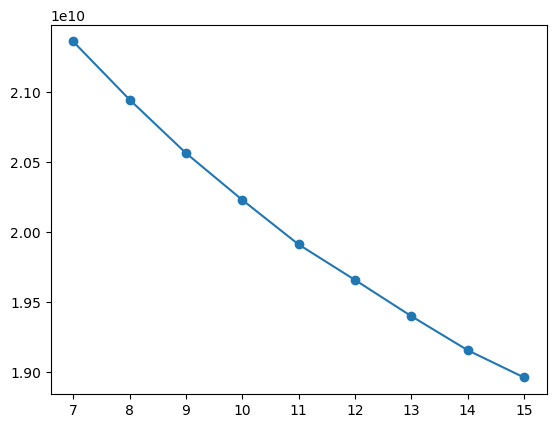

In [48]:
from tqdm.notebook import tqdm
n_c = range(7,16)

inertia= [KMeans(n_clusters =k, random_state = random_state).fit(X_train.reshape(-1, 784)).inertia_ for k in tqdm(n_c)]

plt.plot(n_c, inertia, marker = 'o')
plt.show()

All this training is too long. Let's make a "horseplay" and lower the dimensionality of the data, trying to keep distances between objects. Let's see how this affects speed and accuracy.

Transform the <b>training dataset</b> using the method <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html"><code>TSNE</code></a> from the <code>sklearn</code> library with the parameters specified in your assignment.

In [64]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

tsne = TSNE(n_components = 2, init = 'random', random_state = random_state)
X_tsne = tsne.fit_transform(X_train.reshape(-1,784))


kmeans = KMeans(n_clusters=10, random_state=random_state)
clusters_tsne = kmeans.fit_predict(X_tsne)

# Evaluate the accuracy of the model on the training dataset
accuracy_tsne = accuracy_score(y_train, clusters_tsne)

# Print the accuracy
print("Accuracy on the training dataset:", round(accuracy_tsne, 3))

Accuracy on the training dataset: 0.004


Cluster the resulting dataset using <code>KMeans</code> with the parameters specified in your assignment. Similar to what was done before, reassign cluster labels based on the labels of most objects within the cluster. Evaluate the accuracy of the model on the <b>training dataset</b>.

In [ ]:
# < ENTER YOUR CODE HERE > 

The problem, however, is known. `t-SNE` is a method that does not give a rule for obtaining projections of a multidimensional space onto, for example, a two-dimensional space. Thus, when new data appears, the projections will have to be searched again.

At the same time, once again, we would like to emphasize how unsupervised learning has allowed the construction of a classifier that seems to be the result of solving the problem of supervised learning.